In [57]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import generate_expected_limits
import sympy as sy
from scipy.stats import norm, lognorm
from swyft.plot.mass import _get_jefferys_interval as interval

In [27]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [28]:
names = ['flare0_informed',]
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name

    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1

    priors[name]['net_path'] = {}
    priors[name]['net'] = {}
    for rnd in range(priors[name]['which_truncation']+1):
        round = 'round_'+str(rnd)
        priors[name]['net_path'][round] = (priors[name]['results_path'] + '/train_output/net/trained_network_'
                                                         +round+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')
        priors[name]['net'][round] = network.NetworkCorner(
            nbins=priors[name]['A'].nbins,
            marginals=priors[name]['POI_indices'],
            param_names=priors[name]['A'].param_names,
            **hyperparams_point,
        )
        priors[name]['net'][round].load_state_dict(torch.load(priors[name]['net_path'][round]))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = pickle.load(file)

    if priors[name]['which_truncation'] > 0:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name'])
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples'] = store.get_sample_store()
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
 
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')


/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [29]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')

In [31]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])

In [32]:
def weight(exp,n_bins):
    x = np.linspace(-1,1,n_bins)
    return 0.5+0.5*np.cos(np.pi*np.sign(x)*np.abs(x)**exp)

In [33]:
stdnorm = norm()

In [34]:
def references2D(
    parsed_samples,
    x_freq = None,
    y_freq = None,
    x_exponent = None,
    y_exponent = None,
    x_phase = None,
    y_phase = None,
    min_freq = 1,
    max_freq = 1.4,
    min_freq_gap = 0.15,
    min_exponent = 0.8,
    max_exponent = 1.5,
    min_exponent_gap = 0.3,
):
  
    try:
        samples = parsed_samples['data']
    except IndexError:
        samples = parsed_samples

    data_length = len(samples[0]) 
    start_of_range1 = np.random.randint(0,data_length)
    end_of_range1 = (start_of_range1 + int(data_length/2)) #np.random.randint( start_of_range1+int(data_length/3) , start_of_range1+int(2*data_length/3) )
    exp1 = np.random.uniform(0.5,2)
    exp2 = np.random.uniform(0.5,2)
    range1 = np.arange(start_of_range1,end_of_range1)%data_length
    range2 = np.arange(end_of_range1,end_of_range1+(start_of_range1-end_of_range1)%data_length)%data_length

    reordered_range1 = (np.concatenate([range1,range2])-int(data_length/2))%data_length
    reordered_range2 = (np.concatenate([range2,range1])-int(data_length/2))%data_length
    weights1 = weight(exp1,data_length)[reordered_range1]
    weights2 = weight(exp2,data_length)[reordered_range2]

    samples1 = samples.copy()
    samples2 = samples.copy()
    
    # samples1 = samples[:,range1]
    # samples2 = samples[:,range2]
 
    bin_mins1 = np.min(samples1, axis=0)
    bin_maxes1 = np.max(samples1, axis=0)
    sums_of_standardized_bins1 = np.sum( weights1*((samples1-bin_mins1)/(bin_maxes1-bin_mins1)) ,axis=1)
    sums_of_standardized_bins1 = np.where(np.isinf(sums_of_standardized_bins1),0,sums_of_standardized_bins1)
    max_sum1 = np.max(sums_of_standardized_bins1)
    min_sum1 = np.min(sums_of_standardized_bins1)
    standardized_sums1 = (sums_of_standardized_bins1-min_sum1)/(max_sum1-min_sum1)

    bin_mins2 = np.min(samples2, axis=0)
    bin_maxes2 = np.max(samples2, axis=0)
    sums_of_standardized_bins2 = np.sum( weights2*((samples2-bin_mins2)/(bin_maxes2-bin_mins2)) ,axis=1)
    sums_of_standardized_bins2 = np.where(np.isinf(sums_of_standardized_bins2),0,sums_of_standardized_bins2)
    max_sum2 = np.max(sums_of_standardized_bins2)
    min_sum2 = np.min(sums_of_standardized_bins2)
    standardized_sums2 = (sums_of_standardized_bins2-min_sum2)/(max_sum2-min_sum2)

    sorted_sums1 = np.sort(standardized_sums1)
    sorted_sums2 = np.sort(standardized_sums2)

    fitted_parameters1 = lognorm.fit(standardized_sums1)
    fitted_parameters2 = lognorm.fit(standardized_sums2)
    
    phase_function1 = lognorm(fitted_parameters1[0], fitted_parameters1[1], fitted_parameters1[2]).cdf
    phase_function2 = lognorm(fitted_parameters2[0], fitted_parameters2[1], fitted_parameters2[2]).cdf

    phase_for_check1 = phase_function1(sorted_sums1)
    phase_for_check2 = phase_function2(sorted_sums2)
    phase1 = phase_function1(standardized_sums1)
    phase2 = phase_function2(standardized_sums2)

    if x_phase is None: x_phase = np.random.uniform(0,1)
    if y_phase is None: y_phase = np.random.uniform(0,1)

    freq_range = max_freq-min_freq
    if x_freq is None: x_freq = np.random.uniform(min_freq,max_freq)
    if y_freq is None: y_freq = np.random.uniform(min(x_freq+min_freq_gap,max_freq)-min_freq, freq_range+max(x_freq-min_freq-min_freq_gap,0))%(freq_range) + min_freq
    
    if x_exponent is None: x_exponent = np.random.uniform(min_exponent,1) if x_freq > y_freq else np.random.uniform(1,max_exponent)
    if y_exponent is None: y_exponent = np.random.uniform(min_exponent,min(1,x_exponent-min_exponent_gap)) if x_freq < y_freq else np.random.uniform(max(1,x_exponent+min_exponent_gap),max_exponent)

    x_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase_for_check1)**x_exponent + x_phase ))
    y_values_for_check = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase_for_check2)**y_exponent + y_phase ))
    
    x_values = 0.5 + 0.5*np.sin(2*np.pi*(( x_freq*phase1)**x_exponent + x_phase ))
    y_values = 0.5 + 0.5*np.sin(2*np.pi*(( y_freq*phase2)**y_exponent + y_phase ))

    random_variables = {
        'range1':range1,
        'range2':range2,
        'x_freq':x_freq,
        'y_freq':y_freq,
        'x_exponent':x_exponent,
        'y_exponent':y_exponent,
        'x_phase':x_phase,
        'y_phase':y_phase,
        'sums1':standardized_sums1,
        'sums2':standardized_sums2,
        'sorted_sums1':sorted_sums1,
        'sorted_sums2':sorted_sums2,
        'fitted_parameters1': fitted_parameters1,
        'fitted_parameters2': fitted_parameters2,
    }
    

    return np.array([x_values,y_values]).transpose(), np.array([x_values_for_check,y_values_for_check]).transpose(), random_variables

In [35]:
try:
    del sys.modules['DRP_test']
except KeyError:
    pass
from DRP_test import get_drp_coverage, draw_DRP_samples_fast

In [36]:
name = names[0]
n_samps = 1000
n_prior_samps=10_000
samples = priors[name]['samples'][-n_samps:]
prior_samples = priors[name]['samples_prior'][:n_prior_samps]
which_truncation = priors[name]['which_truncation']
which_grid_point = priors[name]['which_grid_point']
POIs = priors[name]['POI_indices']
A = priors[name]['A']
bounds = np.array(priors[name]['bounds_rounds'][which_grid_point][which_truncation])

draws1d = {}
draws2d = {}
weights1d = {}
weights2d = {}
for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    draws1d[round],draws2d[round],weights1d[round],weights2d[round] = draw_DRP_samples_fast(
        priors[name]['net'][round],
        trainer,
        samples,
        prior_samples,
    )

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [50]:
n_refs = 200
references_1d = [
    references2D(samples)[0][:,[0]] for _ in range(n_refs)
]

references_2d = [
    references2D(samples)[0] for _ in range(n_refs)
]

In [38]:
round_colors = ['r','y','g','c']

In [40]:
which_truncation = 3

In [ ]:
%%time
ecp = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
alpha = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }
f = { 'round_'+str(rnd) : [[{} for ref_list in references_1d],[{} for ref_list in references_2d]] for rnd in range(which_truncation+1) }

for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    for ref_i in range(len(references_1d)):
        for i, key in enumerate(draws1d[round].keys()):
        
            ecp[round][0][ref_i][key], alpha[round][0][ref_i][key], f[round][0][ref_i][key], _ = get_drp_coverage(
                draws1d[round][key],
                samples['params'][:,[POIs[i]]],
                weights = weights1d[round][key],
                theta_names=A.param_names[POIs[i]],
                bounds = np.array(bounds)[[POIs[i]]],
                references = references_1d[ref_i],
            )

rows = len(POIs)

for rnd in range(which_truncation+1):
    round = 'round_'+str(rnd)
    for ref_i in range(len(references_2d)): 
        row = 0
        column = 0
        for i, key in enumerate(draws2d[round].keys()):
            row+=1
            if row >= rows:
                column+=1
                row = 1+column    
            ecp[round][1][ref_i][key], alpha[round][1][ref_i][key], f[round][1][ref_i][key], _ = get_drp_coverage(
                draws2d[round][key],
                samples['params'][:,[column,row]],
                weights = weights2d[round][key],
                theta_names=np.array(A.param_names)[[column,row]],
                bounds = np.array(bounds)[[column,row]],
                references = references_2d[ref_i],
            )

# fig_DRP = plt.figure(figsize = (12, 12))

DRP_fig = plt.figure(figsize = (12, 12))
for i, key in enumerate(draws1d['round_0'].keys()):
    # plt.xlabel("Credibility level (alpha)")
    # plt.ylabel("ECP")
    DRP_fig.add_subplot(rows, rows, i+1+i*rows)
    for rnd in range(which_truncation+1):
        round = 'round_'+str(rnd)
        for ref_i in range(len(references_1d)):
            ecp_ex = np.zeros(len(ecp[round][0][ref_i][key])+1)
            alpha_ex = np.zeros(len(alpha[round][0][ref_i][key])+1)
            ecp_ex[1:] = ecp[round][0][ref_i][key]
            alpha_ex[1:] = alpha[round][0][ref_i][key]
            DRP_fig.axes[-1].plot(alpha_ex, ecp_ex, round_colors[rnd],alpha=1)
        DRP_fig.axes[-1].plot([0,1],[0,1], 'k:')


row = 0
column = 0
for i, key in enumerate(draws2d['round_0'].keys()):
    row+=1
    if row >= rows:
        column+=1
        row = 1+column 
    # plt.xlabel("Credibility level")
    # plt.ylabel("ECP")
    DRP_fig.add_subplot(rows, rows, rows*row+column+1)
    for rnd in range(which_truncation+1):
        round = 'round_'+str(rnd)
        for ref_i in range(len(references_2d)):
            ecp_ex = np.zeros(len(ecp[round][1][ref_i][key])+1)
            alpha_ex = np.zeros(len(alpha[round][1][ref_i][key])+1)
            ecp_ex[1:] = ecp[round][1][ref_i][key]
            alpha_ex[1:] = alpha[round][1][ref_i][key]
            DRP_fig.axes[-1].plot(alpha_ex, ecp_ex, round_colors[rnd], alpha = 1)
        DRP_fig.axes[-1].plot([0,1],[0,1], 'k:')


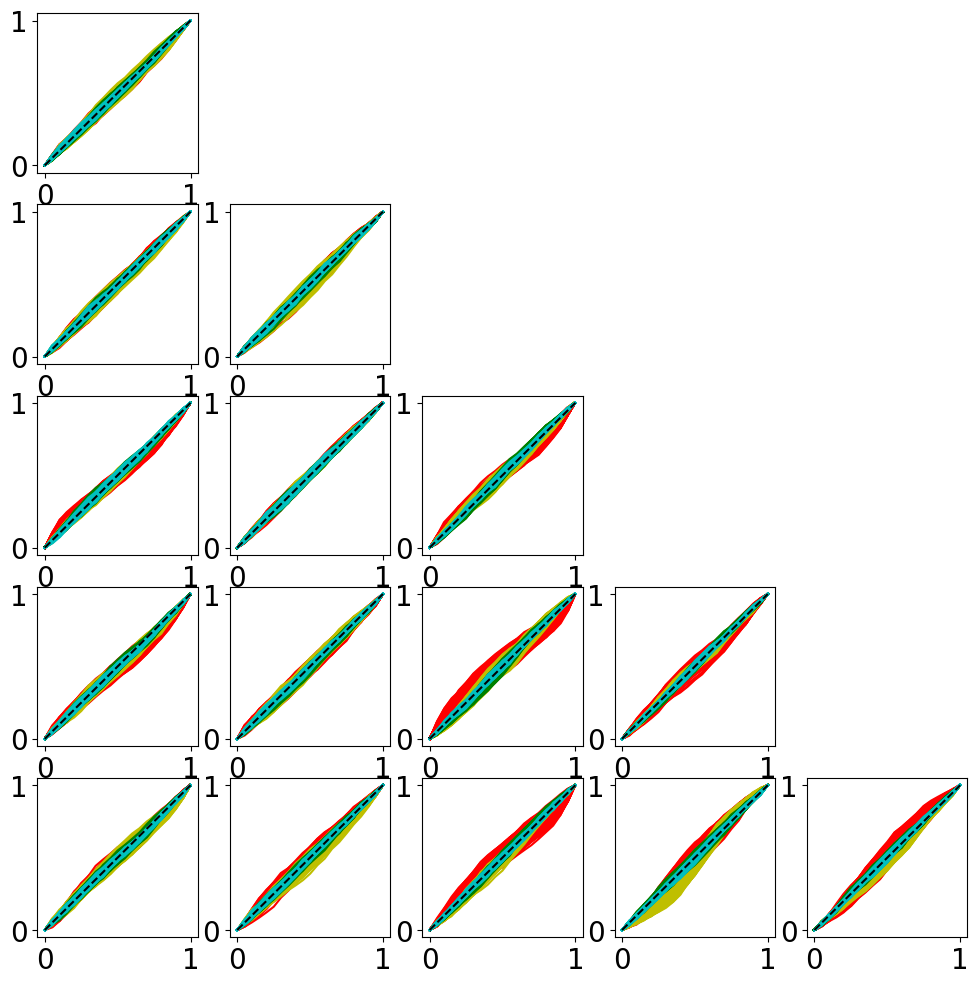

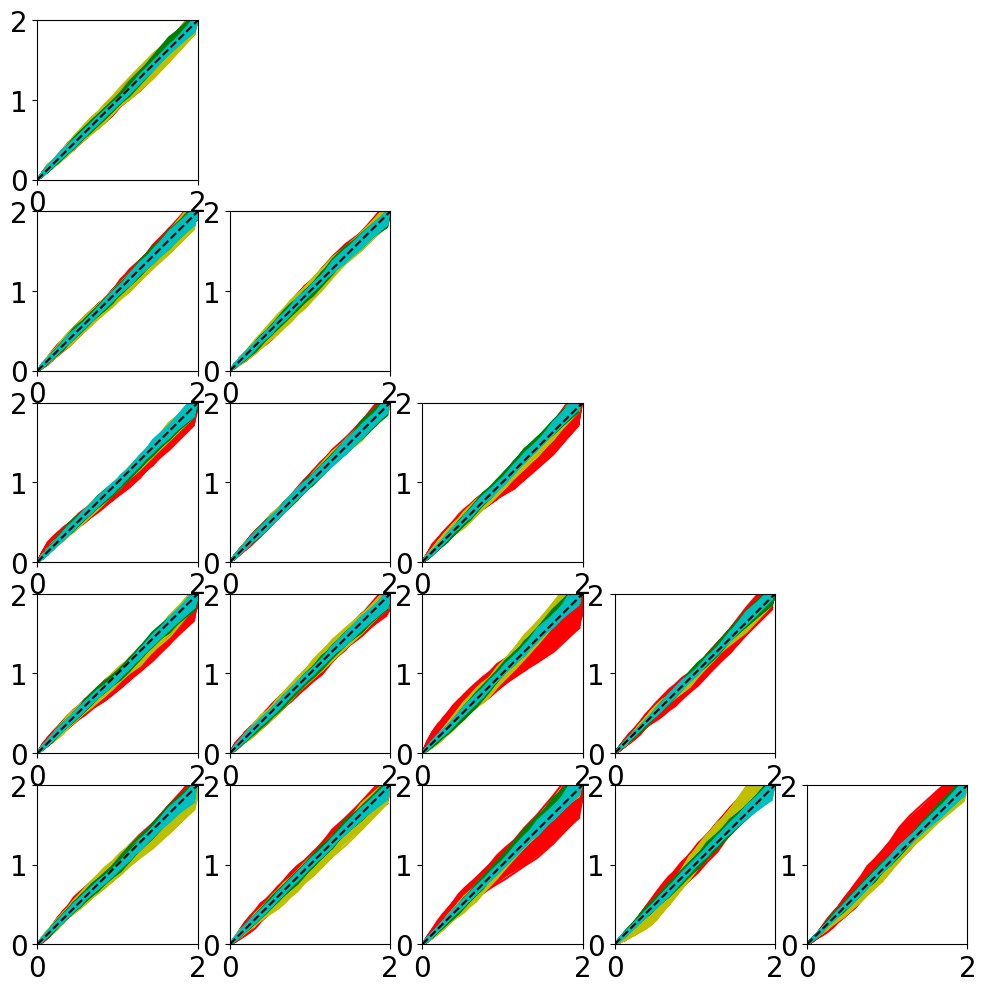

In [64]:
max_z =2
DRP_fig_pp = plt.figure(figsize = (12, 12))
DRP_fig_zz = plt.figure(figsize = (12, 12))
for i, key in enumerate(draws1d['round_0'].keys()):
    # plt.xlabel("Credibility level (alpha)")
    # plt.ylabel("ECP")
    DRP_fig_pp.add_subplot(rows, rows, i+1+i*rows)
    DRP_fig_zz.add_subplot(rows, rows, i+1+i*rows)
    DRP_fig_zz.axes[-1].set_xlim([0,max_z])
    DRP_fig_zz.axes[-1].set_ylim([0,max_z])
    for rnd in range(which_truncation+1):
        round = 'round_'+str(rnd)
        for ref_i in range(len(references_1d)):
            ecp_ex = np.zeros(len(ecp[round][0][ref_i][key])+1)
            alpha_ex = np.zeros(len(alpha[round][0][ref_i][key])+1)
            ecp_ex[1:] = ecp[round][0][ref_i][key]
            alpha_ex[1:] = alpha[round][0][ref_i][key]
            DRP_fig_pp.axes[-1].plot(alpha_ex, ecp_ex, round_colors[rnd],alpha=1)
            DRP_fig_zz.axes[-1].plot(stdnorm.ppf(0.5+alpha_ex/2), stdnorm.ppf(0.5+ecp_ex/2), round_colors[rnd],alpha=1)
            
        DRP_fig_pp.axes[-1].plot([0,1],[0,1], 'k--')
        DRP_fig_zz.axes[-1].plot([0,max_z],[0,max_z], 'k--')
        
row = 0
column = 0
for i, key in enumerate(draws2d['round_0'].keys()):
    row+=1
    if row >= rows:
        column+=1
        row = 1+column 
    # plt.xlabel("Credibility level")
    # plt.ylabel("ECP")
    DRP_fig_pp.add_subplot(rows, rows, rows*row+column+1)
    DRP_fig_zz.add_subplot(rows, rows, rows*row+column+1)
    DRP_fig_zz.axes[-1].set_xlim([0,max_z])
    DRP_fig_zz.axes[-1].set_ylim([0,max_z])
    for rnd in range(which_truncation+1):
        round = 'round_'+str(rnd)
        for ref_i in range(len(references_2d)):
            ecp_ex = np.zeros(len(ecp[round][1][ref_i][key])+1)
            alpha_ex = np.zeros(len(alpha[round][1][ref_i][key])+1)
            ecp_ex[1:] = ecp[round][1][ref_i][key]
            alpha_ex[1:] = alpha[round][1][ref_i][key]
            DRP_fig_pp.axes[-1].plot(alpha_ex, ecp_ex, round_colors[rnd], alpha = 1)
            DRP_fig_zz.axes[-1].plot(stdnorm.ppf(0.5+alpha_ex/2), stdnorm.ppf(0.5+ecp_ex/2), round_colors[rnd],alpha=1)
            
        DRP_fig_pp.axes[-1].plot([0,1],[0,1], 'k--')
        DRP_fig_zz.axes[-1].plot([0,max_z],[0,max_z], 'k--')

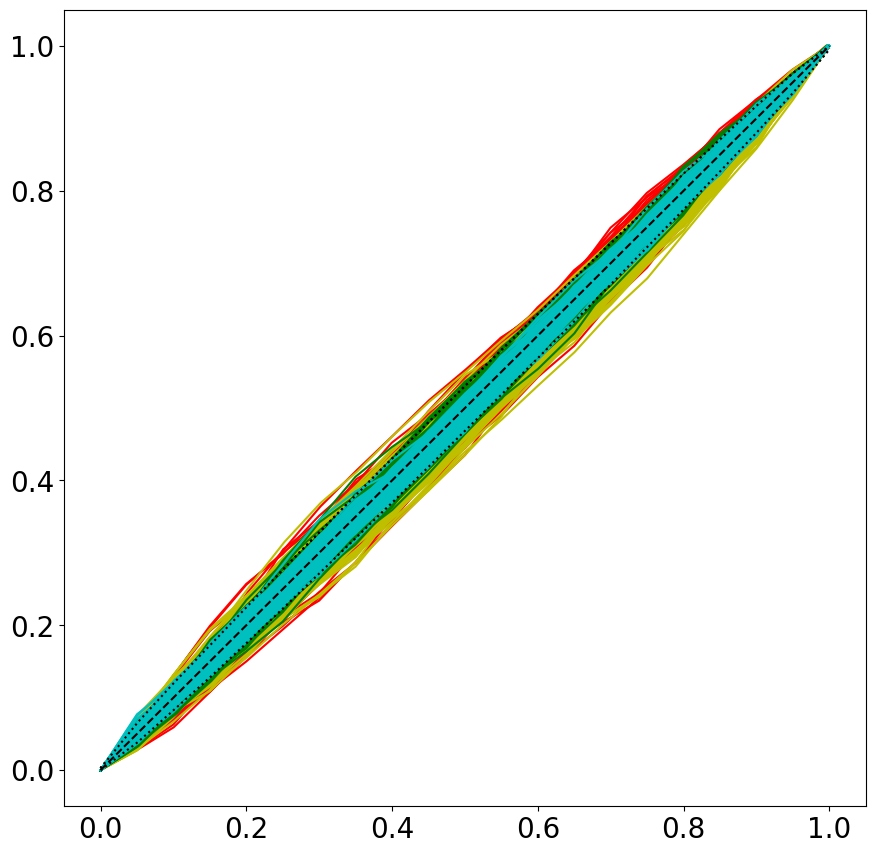

In [62]:
for ax in DRP_fig_pp.axes:
    ax.set_visible(False)
DRP_fig_pp.axes[5].set_visible(True)
DRP_fig_zz.axes[5].plot(stdnorm.ppf(0.5+alpha_ex/2),stdnorm.ppf(0.5+(interval((alpha_ex*n_samps).astype(int),n_samps)[:,0])/2), 'k:')
DRP_fig_zz.axes[5].plot(stdnorm.ppf(0.5+alpha_ex/2),stdnorm.ppf(0.5+(interval((alpha_ex*n_samps).astype(int),n_samps)[:,1])/2), 'k:')
DRP_fig_pp.set_figheight(12*5)
DRP_fig_pp.set_figwidth(12*5)
DRP_fig_pp

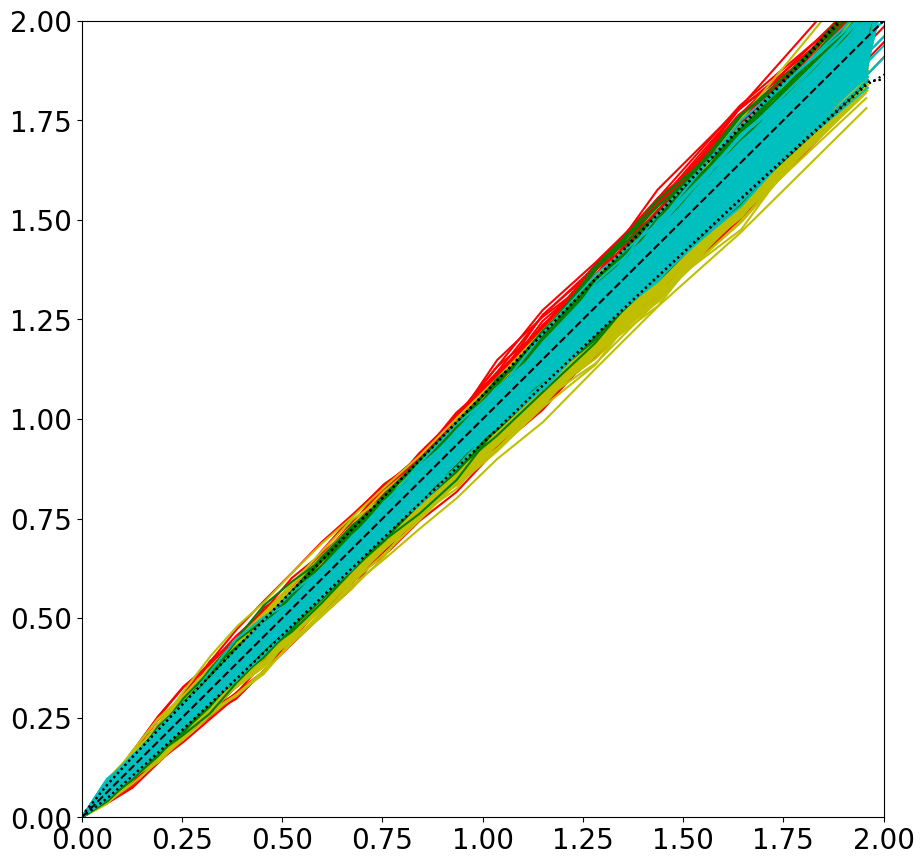

In [61]:
for ax in DRP_fig_zz.axes:
    ax.set_visible(False)
DRP_fig_zz.axes[5].set_visible(True)
DRP_fig_zz.axes[5].plot(stdnorm.ppf(0.5+alpha_ex/2),stdnorm.ppf(0.5+(interval((alpha_ex*n_samps).astype(int),n_samps)[:,0])/2), 'k:')
DRP_fig_zz.axes[5].plot(stdnorm.ppf(0.5+alpha_ex/2),stdnorm.ppf(0.5+(interval((alpha_ex*n_samps).astype(int),n_samps)[:,1])/2), 'k:')
DRP_fig_zz.set_figheight(12*5)
DRP_fig_zz.set_figwidth(12*5)
DRP_fig_zz